In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

#from definitions.aparent_large_all_libs import load_saved_predictor
from definitions.aparent_all_libs import load_saved_predictor


Using TensorFlow backend.


In [55]:

#Define target cleavage loss function
def get_grip_loss(opt_seq_start=0, opt_seq_end=70) :
    
    target_bits=1.8
    entropy_weight=0.0#01
    
    cut_weight = 1.0
    punish_up_c = 0.001
    punish_up_g = 0.001
    punish_up_aa = 0.0
    
    seq_entropy_mse = get_target_entropy_sme(pwm_start=opt_seq_start, pwm_end=opt_seq_end, target_bits=target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=opt_seq_start, pwm_end=opt_seq_end)
    punish_up_g_func = get_punish_g(pwm_start=opt_seq_start, pwm_end=opt_seq_end)
    punish_up_aa_func = get_punish_aa(pwm_start=opt_seq_start, pwm_end=opt_seq_end)
    
    #seq_range = K.reshape(K.arange(205, dtype='float32'), (1, 205))
    seq_range = K.reshape(K.arange(50, dtype='float32'), (1, 50))

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred = predictor_outputs

        #Specify costs
        cut_loss = 0.0
        #cut_loss += 1.0 * K.mean(K.sum(cut_score_pred[..., :90], axis=-1), axis=0)
        cut_loss += - 1.0 * K.mean(K.sum(cut_pred[..., 101:146], axis=-1), axis=0)
        #cut_loss += - 1.0 * K.mean(K.sum(cut_pred[..., :-1] * seq_range, axis=-1), axis=0)
        #cut_loss += - 1.0 * K.mean(K.sum((cut_pred[..., 76:76+50] / K.expand_dims(K.sum(cut_pred[..., 76:76+50], axis=-1), axis=-1)) * seq_range, axis=-1), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = entropy_weight * seq_entropy_mse(pwm)
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func

def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, transform_funcs, n_sequences=1, n_samples=1, library_context='simple', eval_mode='sample', n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True, pwm_transform_func=transform_func, validation_sample_mode='sample')
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        '''
        measure_func = lambda pred_outs: np.expand_dims(np.sum((pred_outs[1][0, :, 76:76+50] if len(pred_outs[1].shape) > 2 else pred_outs[1][:, 76:76+50]) * np.arange(50).reshape(1, -1), axis=-1), axis=-1)
        
        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Avg DSE Cut', plot_pwm_start=0, plot_pwm_end=60, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]
        '''
        
        #Specify callback entities
        measure_func = lambda pred_outs: np.expand_dims(np.sum((pred_outs[1][0, :, 76:76+50] / np.expand_dims(np.sum(pred_outs[1][0, :, 76:76+50], axis=-1), axis=-1) if len(pred_outs[1].shape) > 2 else pred_outs[1][:, 76:76+50] / np.expand_dims(np.sum(pred_outs[1][:, 76:76+50], axis=-1), axis=-1)) * np.arange(50).reshape(1, -1), axis=-1), axis=-1)
        
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            FlexibleSeqPropCutMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Avg DSE Cut', plot_pwm_start=70-65, plot_pwm_end=76+65, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.25))
        ]
        

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        seqprop_predictors.append(seqprop_predictor)

    return seqprop_predictors


In [56]:
#Specfiy file path to pre-trained predictor network
'''
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5'
model_path = os.path.join(save_dir, model_name)
'''
save_dir = os.path.join(os.getcwd(), '../../../aparent/saved_models')
model_name = 'aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'
model_path = os.path.join(save_dir, model_name)



Running optimization experiment 'GripTag'
Optimizing objective 0...
Epoch 1/1
10000/10000 [==============================] - 160s 16ms/step - loss: -6.0373


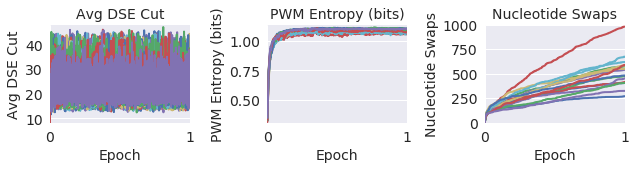

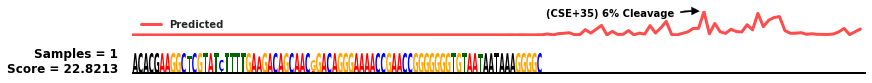

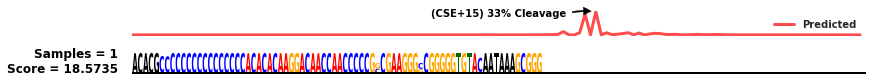

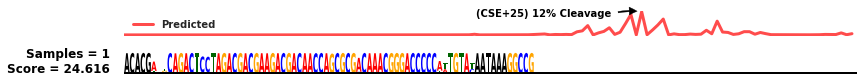

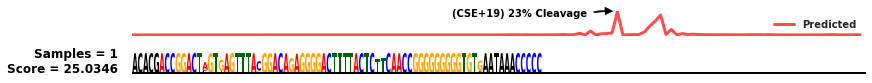

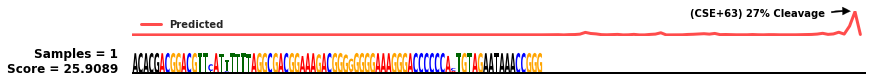

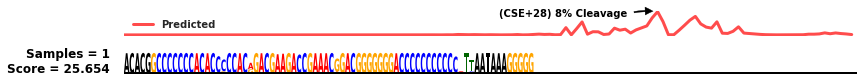

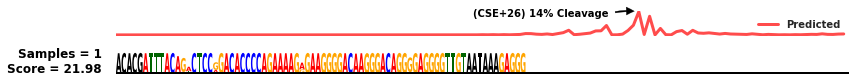

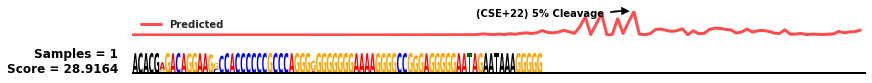

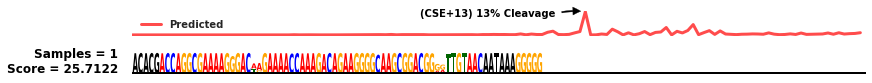

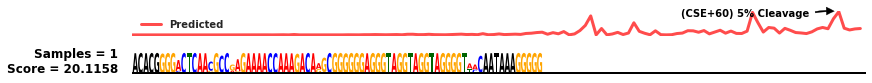

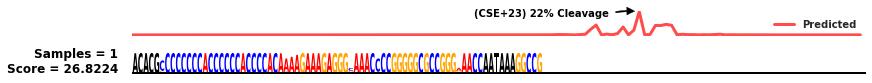

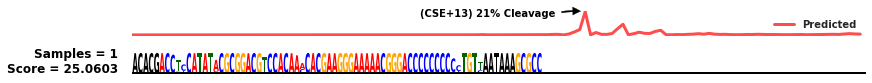

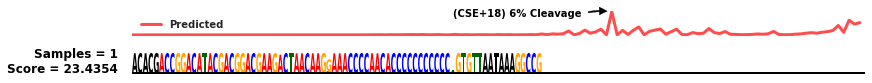

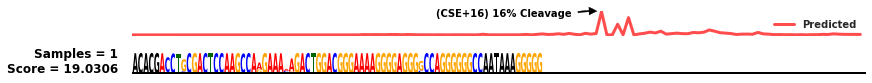

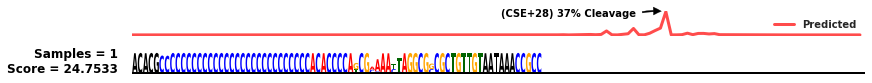

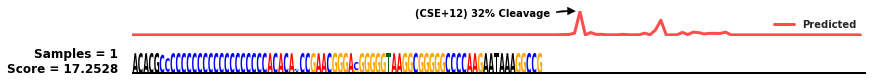

In [57]:

print("Running optimization experiment 'GripTag'")

#Number of PWMs to generate per objective
n_sequences = 16
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = None#1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 10000
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Sequence template
seq_template = 'TCCCTACACGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXTCTTCATGCAATTG'
#Library context
library_context = 'simple'

K.clear_session()

sequence_templates = [
    seq_template
]

losses = [
    get_grip_loss(opt_seq_start=10, opt_seq_end=70)
]

transforms = [
    None#get_nop_transform()
]
seqprop_predictors = run_seqprop(sequence_templates, losses, transforms, n_sequences, n_samples, library_context, eval_mode, n_epochs, steps_per_epoch)
seqprop_predictor = seqprop_predictors[0]


16384/16384 [==============================] - 30s 2ms/step
Sequence 0


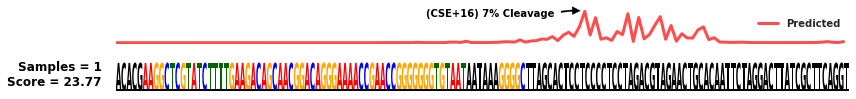

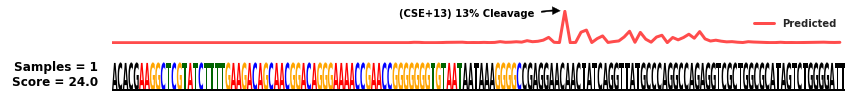

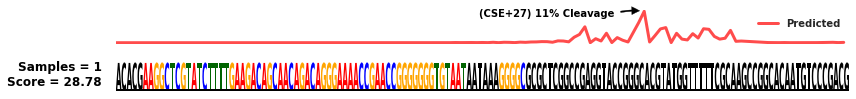

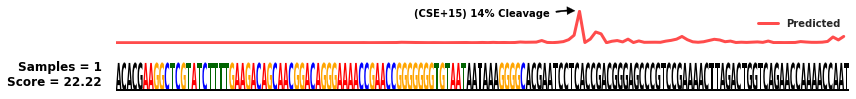

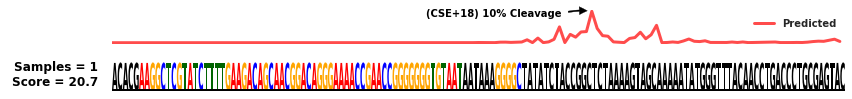

Mean Proximal Isoform %    = 0.76
Mean Proximal Cut Position = 23.93


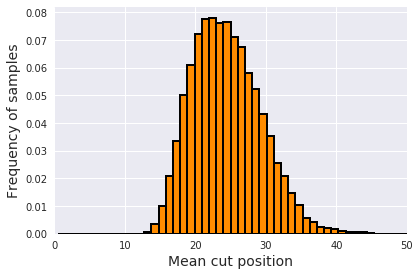

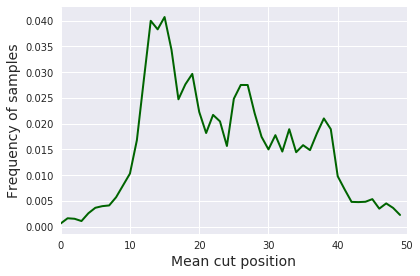

Sequence 1


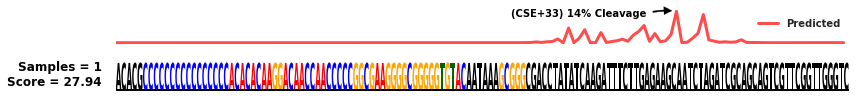

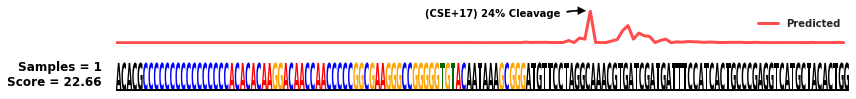

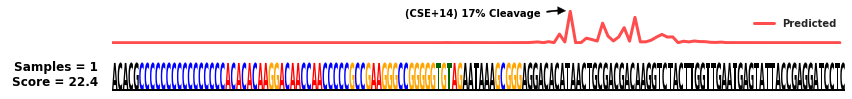

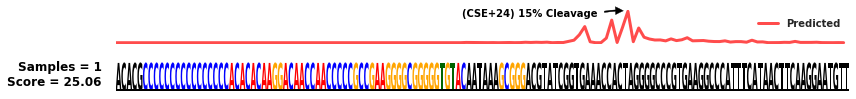

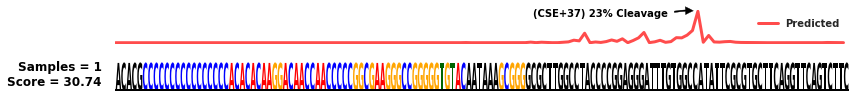

Mean Proximal Isoform %    = 0.83
Mean Proximal Cut Position = 23.95


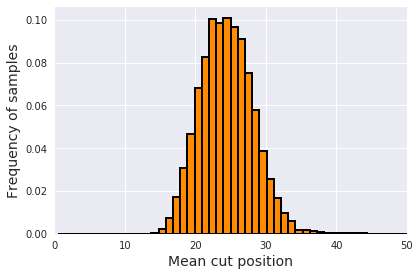

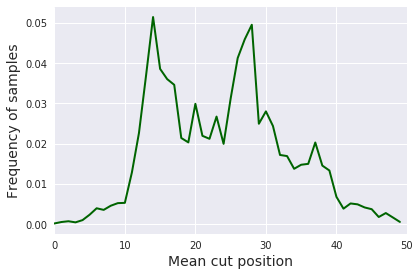

Sequence 2


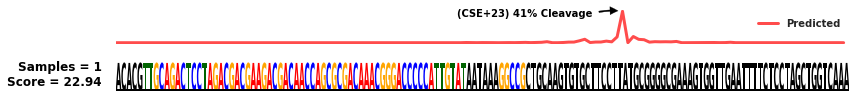

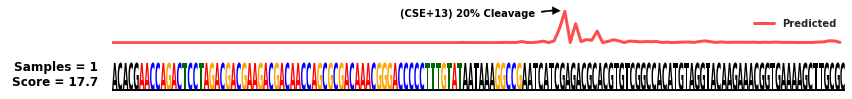

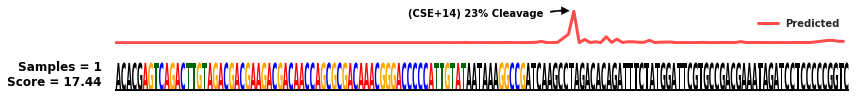

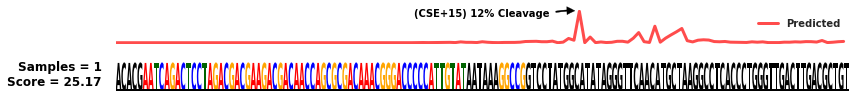

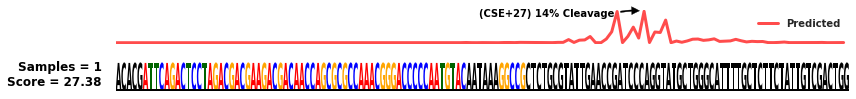

Mean Proximal Isoform %    = 0.7
Mean Proximal Cut Position = 23.11


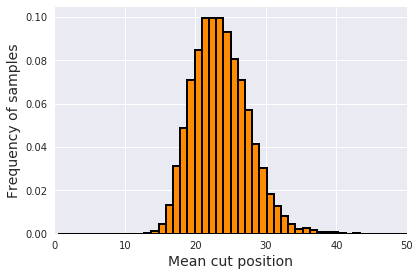

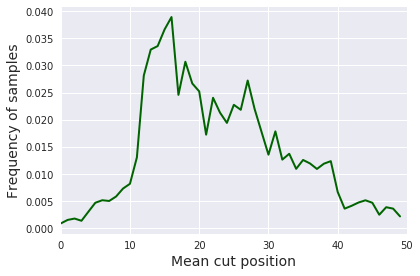

Sequence 3


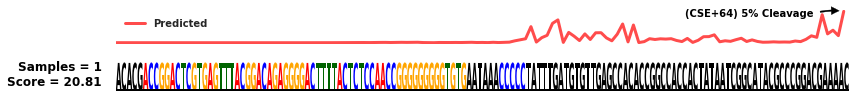

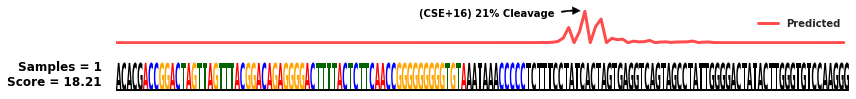

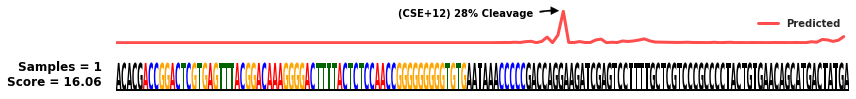

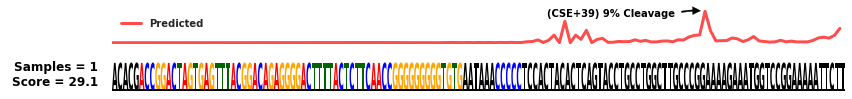

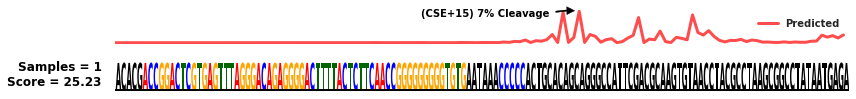

Mean Proximal Isoform %    = 0.67
Mean Proximal Cut Position = 23.88


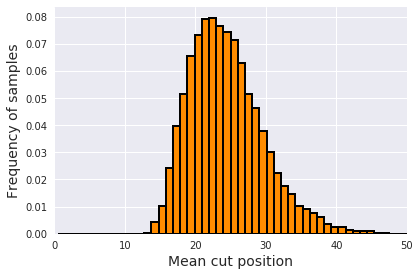

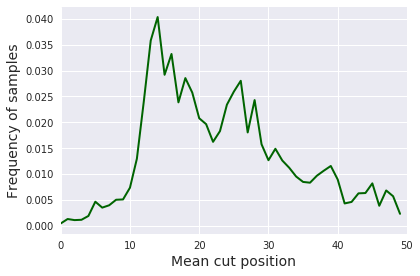

Sequence 4


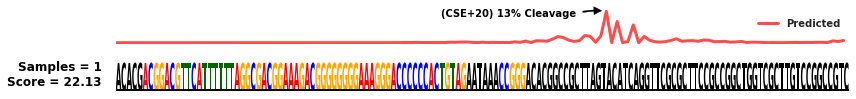

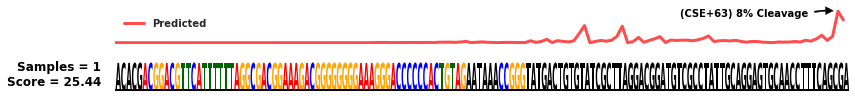

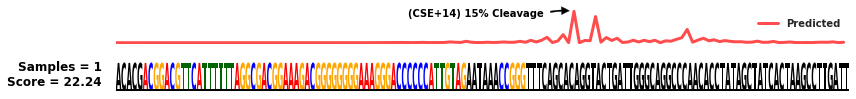

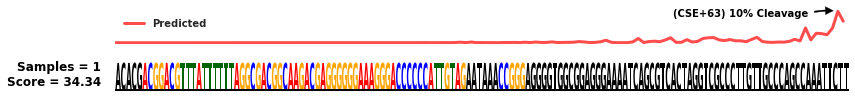

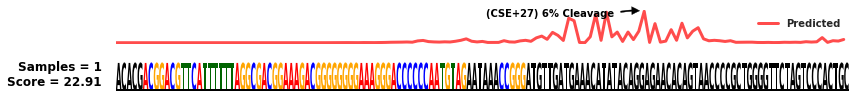

Mean Proximal Isoform %    = 0.61
Mean Proximal Cut Position = 24.31


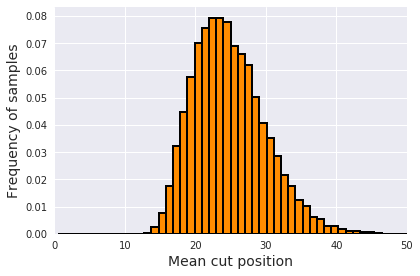

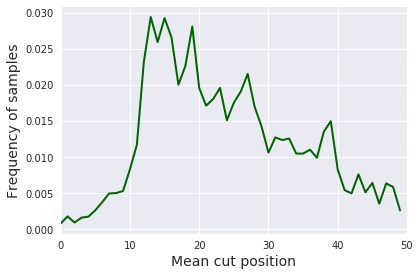

Sequence 5


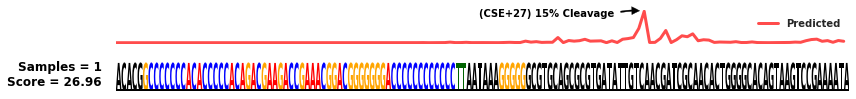

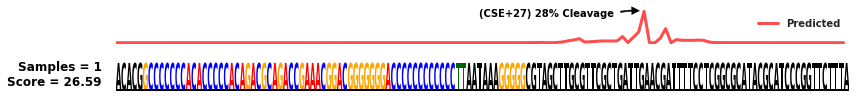

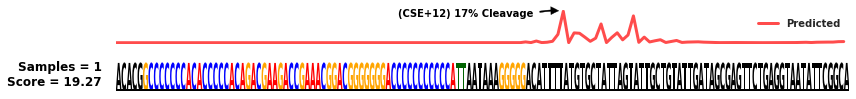

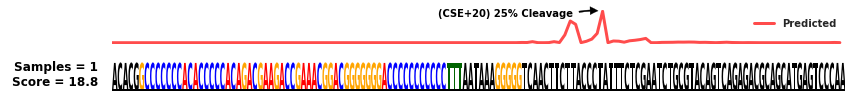

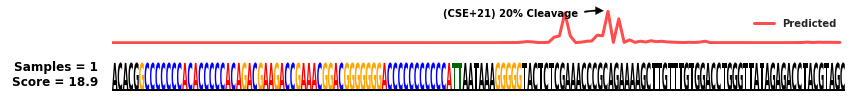

Mean Proximal Isoform %    = 0.79
Mean Proximal Cut Position = 23.79


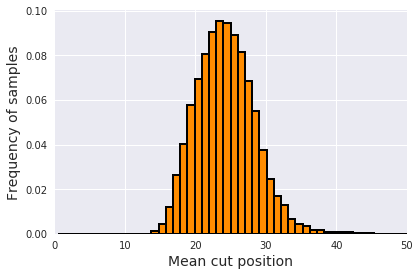

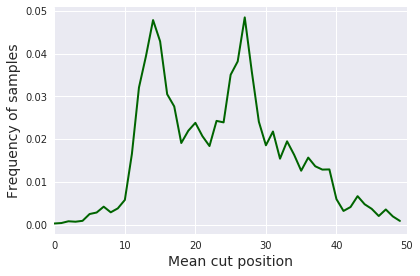

Sequence 6


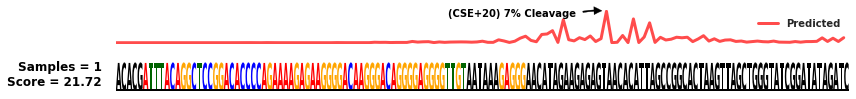

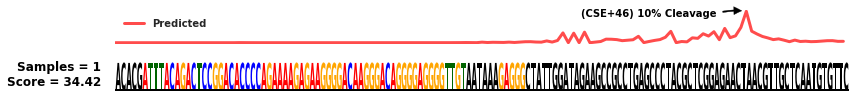

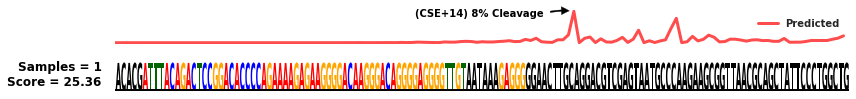

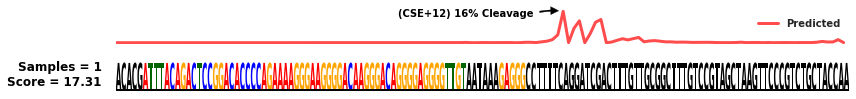

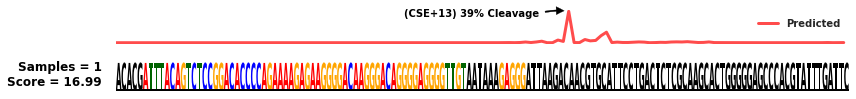

Mean Proximal Isoform %    = 0.67
Mean Proximal Cut Position = 23.42


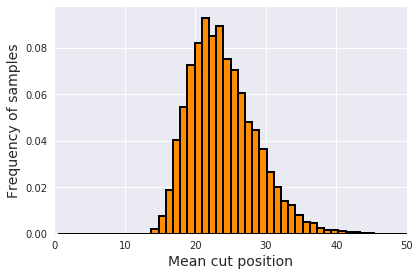

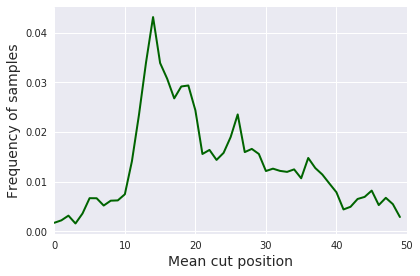

Sequence 7


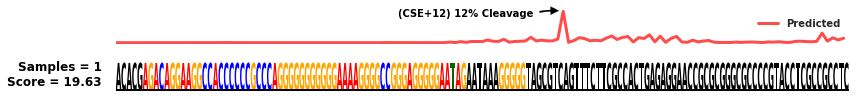

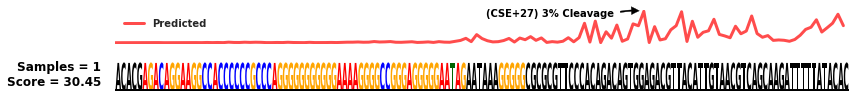

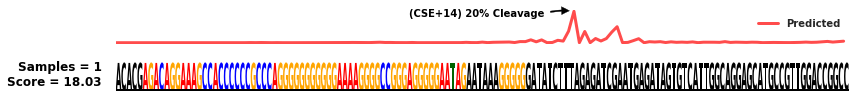

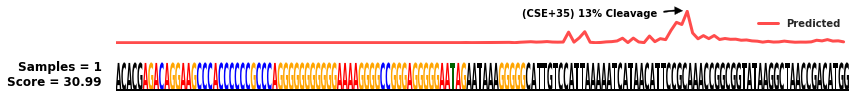

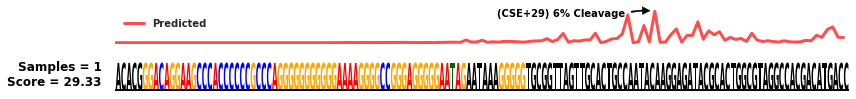

Mean Proximal Isoform %    = 0.66
Mean Proximal Cut Position = 23.7


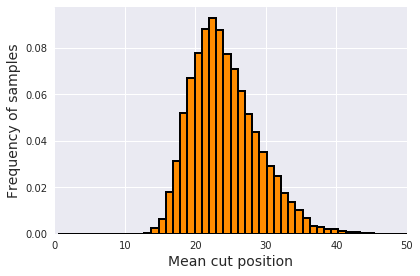

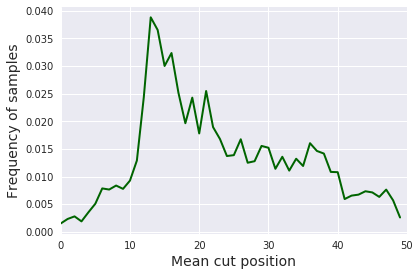

Sequence 8


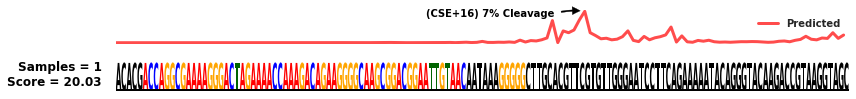

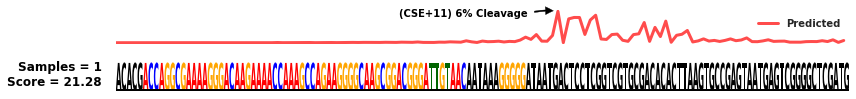

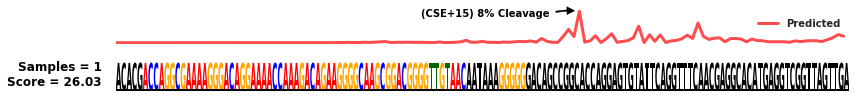

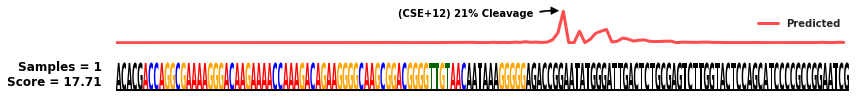

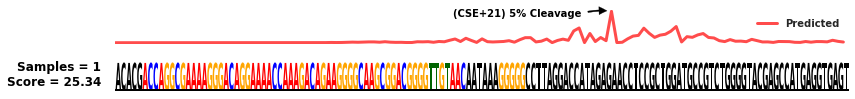

Mean Proximal Isoform %    = 0.64
Mean Proximal Cut Position = 24.4


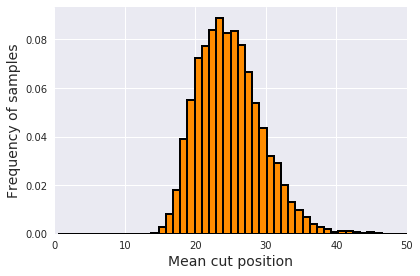

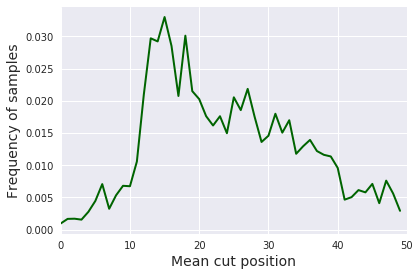

Sequence 9


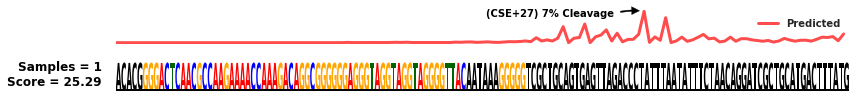

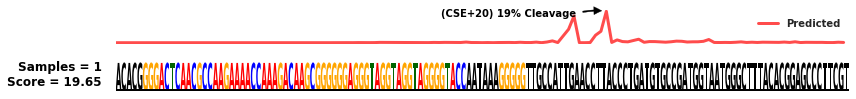

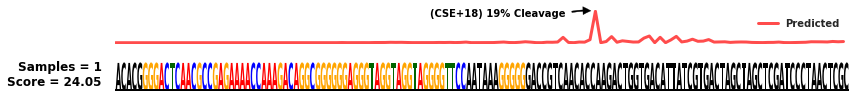

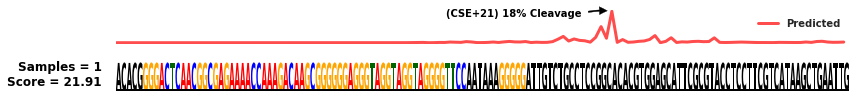

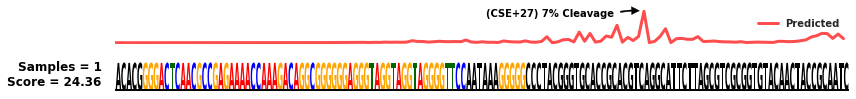

Mean Proximal Isoform %    = 0.62
Mean Proximal Cut Position = 24.38


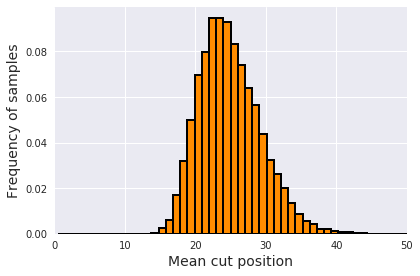

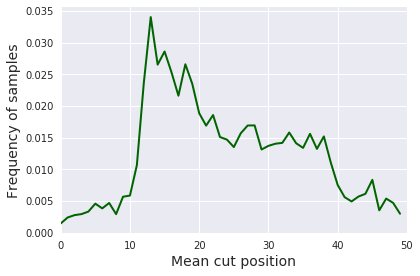

Sequence 10


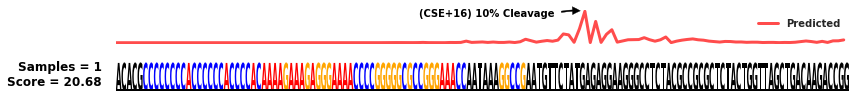

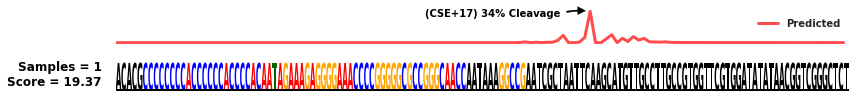

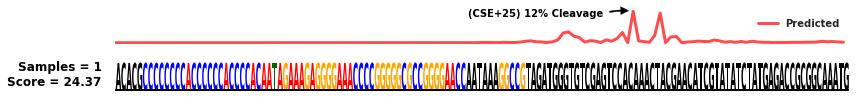

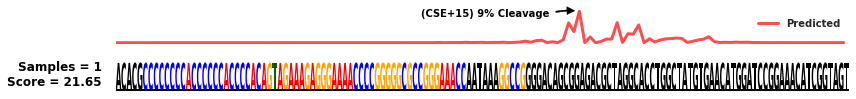

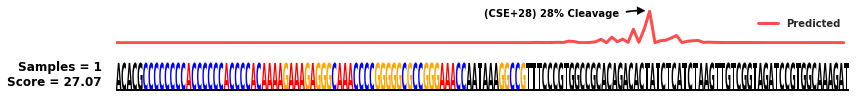

Mean Proximal Isoform %    = 0.8
Mean Proximal Cut Position = 23.44


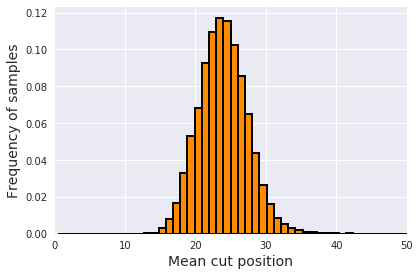

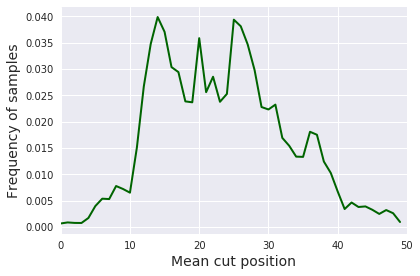

Sequence 11


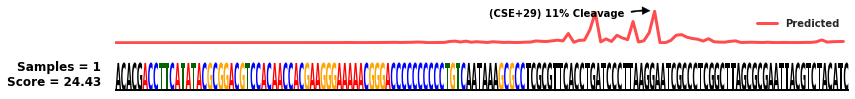

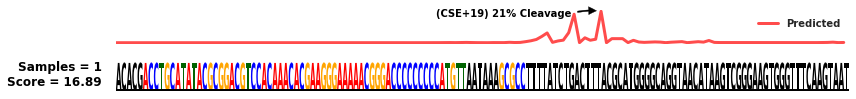

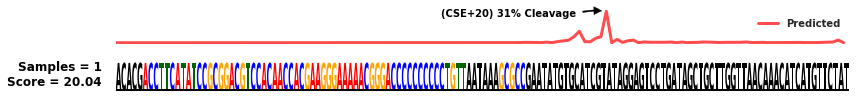

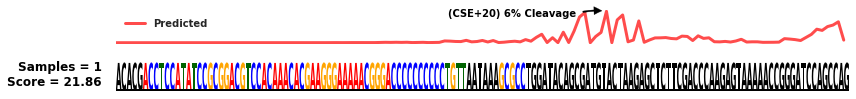

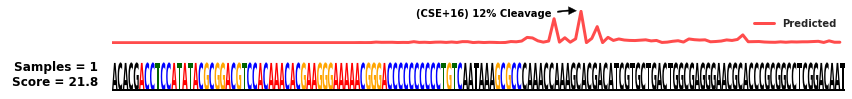

Mean Proximal Isoform %    = 0.71
Mean Proximal Cut Position = 24.06


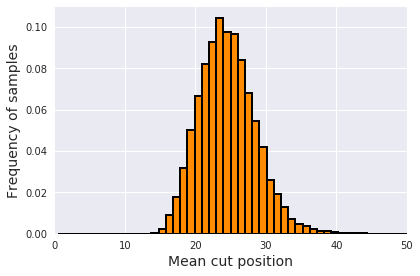

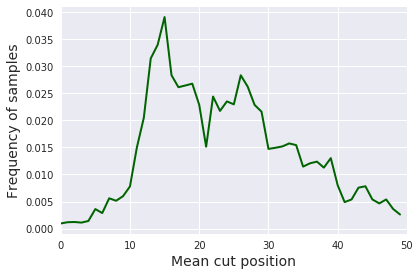

Sequence 12


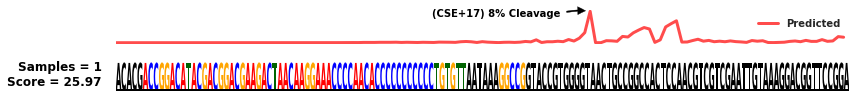

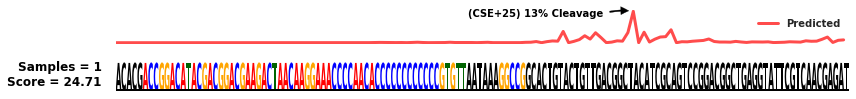

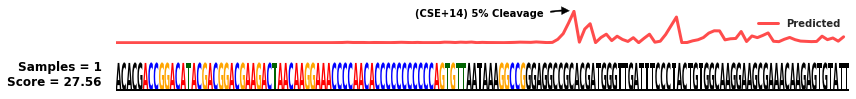

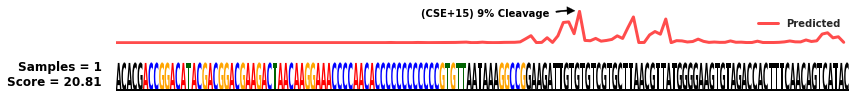

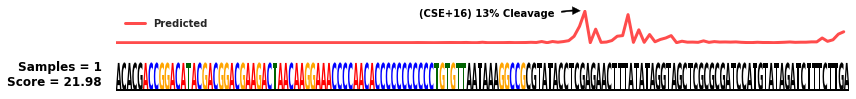

Mean Proximal Isoform %    = 0.72
Mean Proximal Cut Position = 22.95


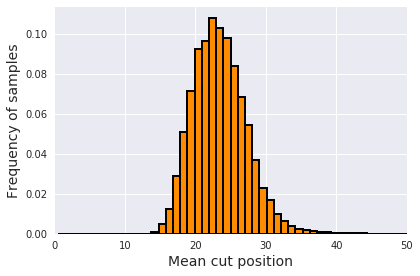

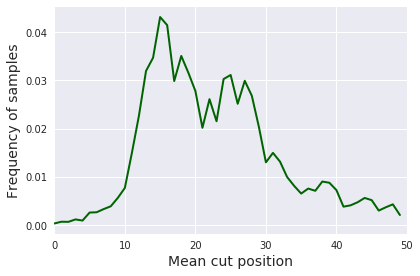

Sequence 13


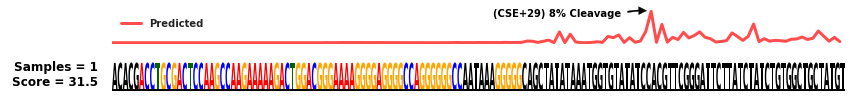

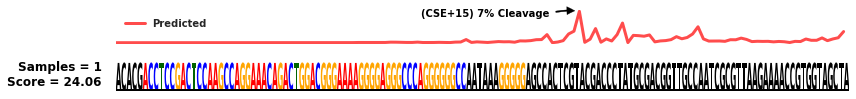

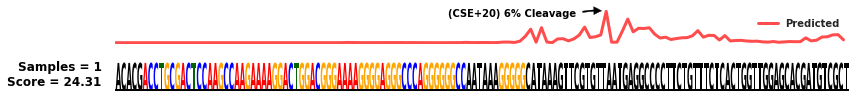

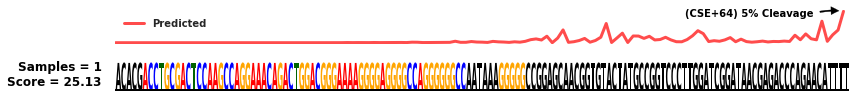

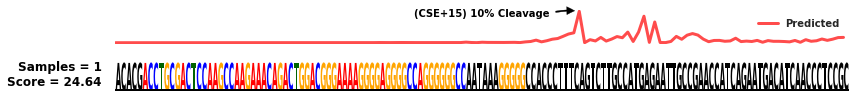

Mean Proximal Isoform %    = 0.53
Mean Proximal Cut Position = 25.52


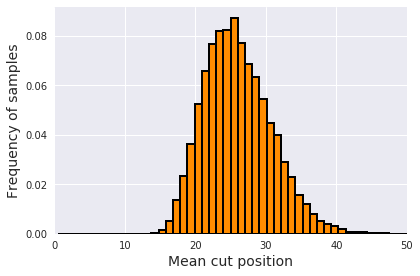

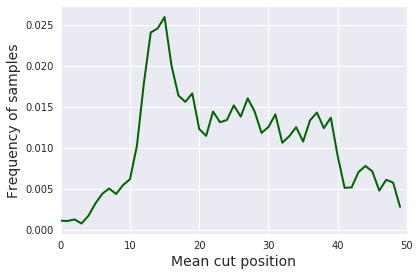

Sequence 14


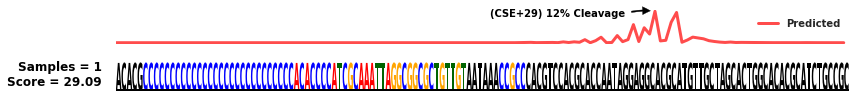

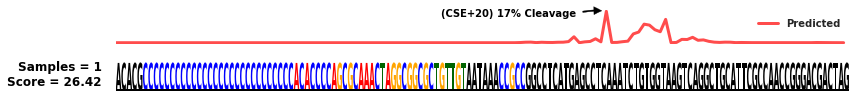

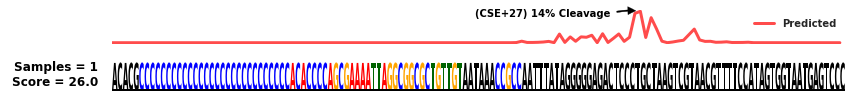

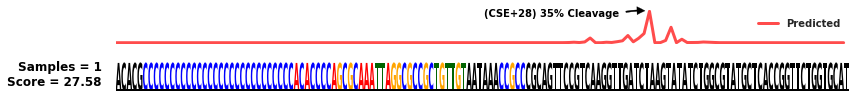

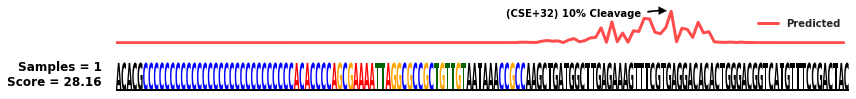

Mean Proximal Isoform %    = 0.9
Mean Proximal Cut Position = 26.08


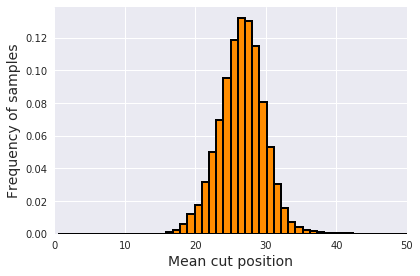

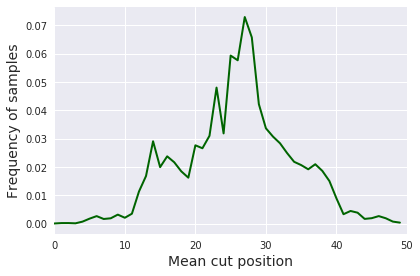

Sequence 15


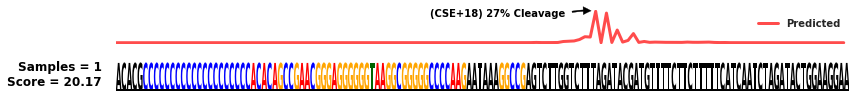

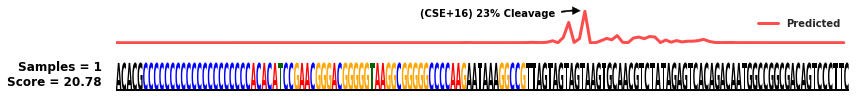

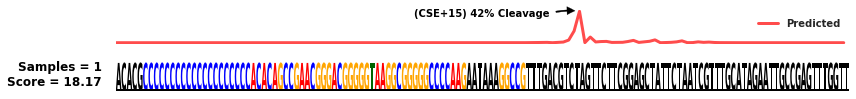

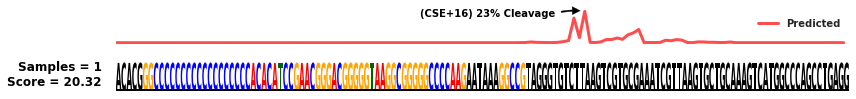

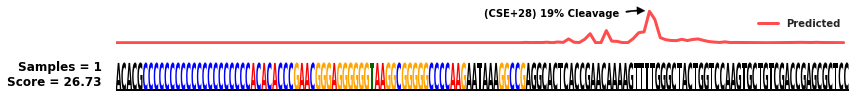

Mean Proximal Isoform %    = 0.87
Mean Proximal Cut Position = 23.47


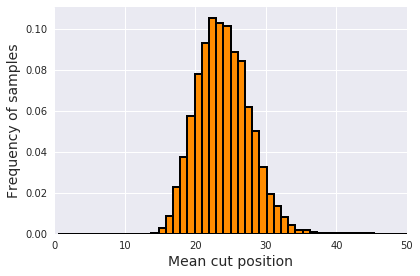

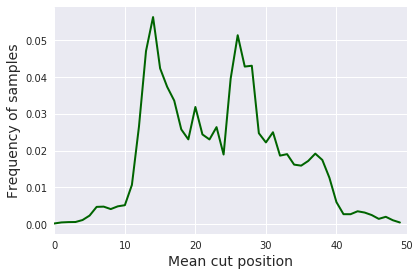

In [58]:
import seaborn as sns
sns.set();

import warnings
warnings.simplefilter("ignore")

#Retrieve optimized PWMs and predicted cleavage distributionns
_, optimized_pwm, _, _, _, _, _ = seqprop_predictor.predict(x=None, steps=1)

n_valid_samples = 16384#256

_, _, sampled_pwm, iso_pred, cut_pred, _, _ = seqprop_predictor.predict(x=None, steps=n_valid_samples, verbose=True)
'''
sampled_pwm = sampled_pwm[:, 0, :, :, 0]
iso_pred = iso_pred[:, 0, :]
cut_pred = cut_pred[:, 0, :]
'''
sampled_pwm = np.reshape(sampled_pwm[:, :, :, 0], (n_valid_samples, n_sequences, 205, 4))
iso_pred = np.reshape(iso_pred[:, :], (n_valid_samples, n_sequences, 1))
cut_pred = np.reshape(cut_pred[:, :], (n_valid_samples, n_sequences, 206))

n_seqs_to_plot = 5

histo_range = [0, 50 + 1]
histo_nbins = 50
histo_width = (histo_range[1] - histo_range[0]) / histo_nbins

for sequence_ix in range(n_sequences) :
    
    print("Sequence " + str(sequence_ix))

    mean_cuts = []
    for sample_ix in range(n_valid_samples) :
        
        #mean_cut = np.dot(cut_pred[sample_ix, sequence_ix, :-1] / np.sum(cut_pred[sample_ix, sequence_ix, :-1]), np.arange(205)) - 76
        mean_cut = np.dot(cut_pred[sample_ix, sequence_ix, 76:76+50] / np.sum(cut_pred[sample_ix, sequence_ix, 76:76+50]), np.arange(50))
        
        mean_cut = round(mean_cut, 2)
        mean_cuts.append(mean_cut)

        if sample_ix < min(n_valid_samples, n_seqs_to_plot) :
            plot_start = 70-65
            plot_end = 76+65

            plot_seqprop_logo(np.expand_dims(sampled_pwm[sample_ix, sequence_ix, :, :], axis=0), np.array([mean_cut]).reshape(-1, 1), np.expand_dims(cut_pred[sample_ix, sequence_ix, :], axis=0), annotate_peaks='max', sequence_template=seq_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='score', plot_start=plot_start, plot_end=plot_end, save_figs=False, fig_name=None, fig_dpi=300)

    mean_cut_histo, histo_bins = np.histogram(np.array(mean_cuts), bins=histo_nbins, range=histo_range, density=True)
    
    prox_iso = np.mean(np.sum(cut_pred[:, sequence_ix, 76:76+50], axis=-1), axis=0)
    prox_pos = np.mean(mean_cuts)
    print("Mean Proximal Isoform %    = " + str(round(prox_iso, 2)))
    print("Mean Proximal Cut Position = " + str(round(prox_pos, 2)))
    
    f = plt.figure(figsize=(6, 4))
    
    plt.bar(histo_bins[1:], mean_cut_histo, width=histo_width, linewidth=2, color='darkorange', edgecolor='black')

    plt.xlabel('Mean cut position', fontsize=14)
    plt.ylabel('Frequency of samples', fontsize=14)
    
    plt.xlim(0, 50)

    plt.tight_layout()

    plt.show()
    
    
    mean_profile = np.mean(cut_pred[:, sequence_ix, :-1], axis=0)

    f = plt.figure(figsize=(6, 4))
    
    plt.plot(np.arange(50), mean_profile[76:76+50], linewidth=2, color='darkgreen')
    
    plt.xlabel('Mean cut position', fontsize=14)
    plt.ylabel('Frequency of samples', fontsize=14)
    
    plt.xlim(0, 50)

    plt.tight_layout()

    plt.show()
